# Import

In [1]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import ticker



# Variables

In [2]:
fs = 20 # let's not hardcode all fontsizes either

wp = 1.37*10**16  #[Hz]
vf = 1.40*10**15  #[nm/s]
Gamma_bulk = 0.476*10**14  #[Hz] # from Ashcroft-Mermin (at 100°C)
c = 299792458*10**9 # [nm/s]
z = 10**7 # [nm]
# guesses of best fit values from chi-squared maps: use those as initial guesses for the size dependent fits
epsilonm_guess = 2.3
rho_guess = 3.5*10**-9
R_guess = 5
f_guess = 2*10**-6
epsilonm_fit = epsilonm_guess
rho_fit = rho_guess
R_fit = R_guess

bulk_data = pd.read_csv("bulk gold dieletric functions.txt", sep="\t", header=None)
bulk_data.columns = ["lambda", "epsilon1", "epsilon2"]
epsilon1_bulk = np.array(bulk_data["epsilon1"]) # from 200nm to 900nm
epsilon2_bulk = np.array(bulk_data["epsilon2"]) # from 200nm to 900nm

np_data = pd.read_csv("G01-NPs.dat", sep="\t", header=None)
np_data.columns = ["lambda", "absorbance"]
absorbance = np.array(np_data["absorbance"])
absorbance_r = absorbance[50:201]  # _r variables are restricted to the selected fit region # I've also tried [70:171]

l = np.array(np_data["lambda"])  # from 400nm to 800nm
l_bulk = np.array(bulk_data["lambda"]) # from 200nm to 900nm
l_r = l[50:201]

# FUNCTION DEFINITIONS

In [3]:
def Gamma(R): # [Hz]
    return Gamma_bulk * (1+(np.pi*vf/(4*Gamma_bulk*R)))

def omega(l):  #[Hz]
    return 2*np.pi*c/l

def epsilon1(l, R):
    l_index=l.astype(int)-200
    try:
        e1 = epsilon1_bulk[l_index]+wp**2 * (1/(omega(l)**2+Gamma_bulk**2)-1/(omega(l)**2+Gamma(R)**2))
        return e1
    except:
        print("Invalid wavelength")
          
def epsilon2(l, R):
    l_index=l.astype(int)-200
    try:
        e2 = epsilon2_bulk[l_index]-wp**2/omega(l) * (Gamma_bulk/(omega(l)**2+Gamma_bulk**2)-Gamma(R)/(omega(l)**2+Gamma(R)**2))
        return e2
    except:
        print("Invalid wavelength")

def Absorbance(l, R, epsilonm, rho): # rho = [nm**(-3)]
    return np.log10(np.e)*9*z*omega(l)/c*epsilonm**(3/2)*4/3*np.pi*R**3*rho*epsilon2(l, R)/((epsilon1(l, R)+2*epsilonm)**2+(epsilon2(l, R))**2)

def Absorbance_f(l, R, epsilonm, f):
    return np.log10(np.e)*9*z*omega(l)/c*epsilonm**(3/2)*f*epsilon2(l, R)/((epsilon1(l, R)+2*epsilonm)**2+(epsilon2(l, R))**2)

def Absorbance_epsilonmfix(l, R, rho):
    return Absorbance(l, R, epsilonm_guess, rho)

def Absorbance_JC(l, epsilonm, f):
    l=l.astype(int)-200
    return np.log10(np.e)*9*z*omega(l)/c*epsilonm**(3/2)*f*epsilon2_bulk[l]/((epsilon1_bulk[l]+2*epsilonm)**2+(epsilon2_bulk[l])**2)

def Chi(observed, expected):
    return ((observed-expected)**2/expected).sum()

def Chi_R_rho(R, rho):
    return Chi(absorbance_r, Absorbance(l_r, R, epsilonm_guess, rho))

def Chi_R_epsilonm(R, epsilonm): # only accounts for the chi squared in the selected fit range
    return Chi(absorbance_r, Absorbance(l_r, R, epsilonm, rho_fit))

def multiwrite(outfile, string):
    outfile.write(string + "\n")
    print(string)

#  FITTING: Johnson and Christy

In [4]:
par_fit_JC, par_cov_JC = curve_fit(Absorbance_JC, l, absorbance, p0=(epsilonm_guess, 2*10**-6))
Absorbance_JC_fitted = Absorbance_JC(l, epsilonm=par_fit_JC[0], f=par_fit_JC[1])

par_fit_JC_r, par_cov_JC_r = curve_fit(Absorbance_JC, l_r, absorbance_r, p0=(epsilonm_guess, 2*10**-6))
Absorbance_JC_fitted_r = Absorbance_JC(l, epsilonm=par_fit_JC_r[0], f=par_fit_JC_r[1])

with open("outputfile.txt", "w") as outfile:
    multiwrite(outfile, "Full curve JC fit:")
    multiwrite(outfile, "espilonm_JC = " + str(par_fit_JC[0]) + " with error " + str(np.sqrt(par_cov_JC[0,0])))
    multiwrite(outfile, "f_JC = " + str(par_fit_JC[1]) + " with error " + str(np.sqrt(par_cov_JC[1,1])))
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_JC_fitted)))
    multiwrite(outfile, "")
    
    multiwrite(outfile, "Restricting the JC fit to 470nm-570nm:")
    multiwrite(outfile, "espilonm_JC = " + str(par_fit_JC_r[0]) + " with error " + str(np.sqrt(par_cov_JC_r[0,0])))
    multiwrite(outfile, "f_JC = " + str(par_fit_JC_r[1]) + " with error " + str(np.sqrt(par_cov_JC_r[1,1])))
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_JC_fitted_r)))
    multiwrite(outfile, "")

Full curve JC fit:
espilonm_JC = 2.3332225378831177 with error 0.02154811267205331
f_JC = 8.220511279213427e-07 with error 1.4735382995249881e-08
Chi-squared = 36.23919803763101

Restricting the JC fit to 470nm-570nm:
espilonm_JC = 2.296952133299161 with error 0.03092277392338673
f_JC = 8.41099100108054e-07 with error 2.3658786847627182e-08
Chi-squared = 37.51093164516652



# PLOTTING

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


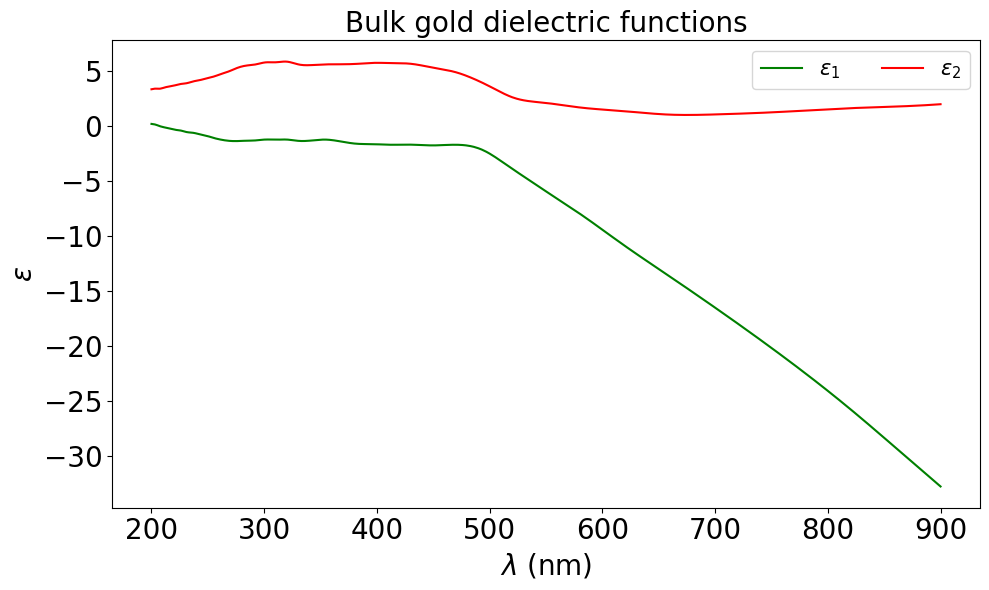

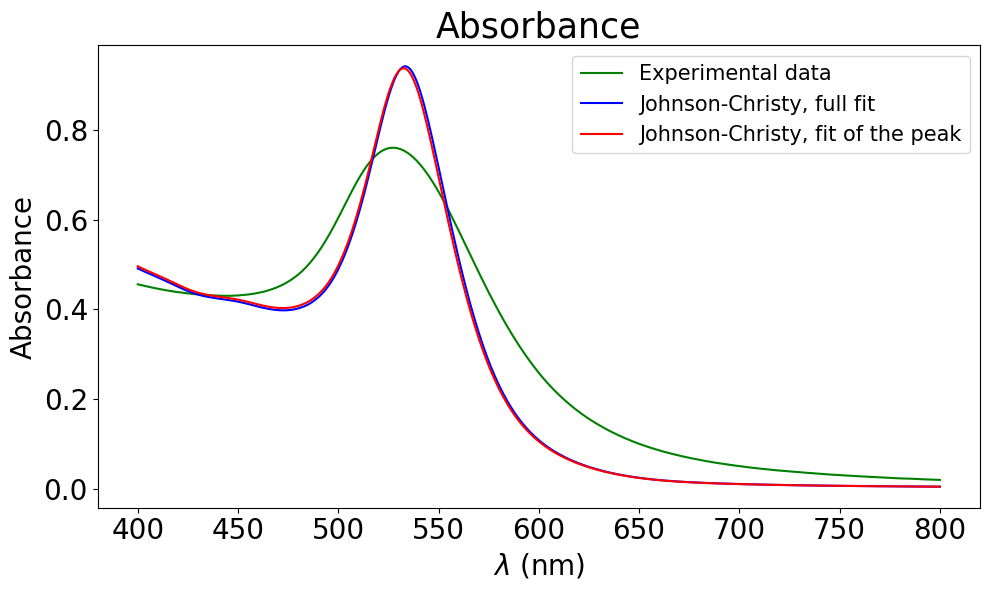

In [5]:
# Bulk gold dielectric functions
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(l_bulk, epsilon1_bulk, color="green", label=r"$\epsilon_1$")
plt.plot(l_bulk, epsilon2_bulk, color="red", label=r"$\epsilon_2$")
plt.title("Bulk gold dielectric functions", fontdict={"fontname": "Calibri", "fontsize": fs})
plt.xlabel(r"$\lambda$ (nm)", fontdict={"fontsize": fs})
plt.xticks(fontsize=fs)
plt.ylabel(r"$\epsilon$", fontdict={"fontsize": fs})
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs//4*3, ncol=2)
plt.tight_layout()

# JC plots
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(l, absorbance, color="green", label=r"Experimental data")
plt.plot(l, Absorbance_JC_fitted, color="blue", label=r"Johnson-Christy, full fit")
plt.plot(l, Absorbance_JC_fitted_r, color="red", label=r"Johnson-Christy, fit of the peak")
plt.title("Absorbance", fontdict={"fontname": "Calibri", "fontsize": fs+5})
plt.xlabel(r"$\lambda$ (nm)", fontdict={"fontsize": fs})
plt.xticks(fontsize=fs)
plt.ylabel("Absorbance", fontdict={"fontsize": fs})
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs//4*3, ncol=1)
plt.tight_layout()

#  FITTING: Size dependent, initial triple fit

In [6]:
# Initial 3 parameter fit: this can give the initial guess for the more refined fit later, but results are not totally realiable
# Indeed rho*R**3 is constant, so the dependency on R and rho is very weak and there probably are a lot of local minima
par_fit, par_cov = curve_fit(Absorbance, l_r, absorbance_r, p0=(R_guess, epsilonm_guess, rho_guess))
Absorbance_fitted = Absorbance(l, R=par_fit[0], epsilonm=par_fit[1], rho=par_fit[2])

with open("outputfile.txt", "a") as outfile:
    multiwrite(outfile, "Fit restricted to 470nm-570nm:")
    multiwrite(outfile, "R = " + str(par_fit[0]) + " nm, with error " + str(np.sqrt(par_cov[0,0])) + " nm")
    multiwrite(outfile, "espilonm = " + str(par_fit[1]) + " with error " + str(np.sqrt(par_cov[1,1])))
    multiwrite(outfile, "rho = " + str(par_fit[2]) + " nm**-3, with error " + str(np.sqrt(par_cov[2,2])) + " nm**-3")
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_fitted)))
    multiwrite(outfile, "")


Fit restricted to 470nm-570nm:
R = 3.066609688932729 nm, with error 0.07456908844979904 nm
espilonm = 2.109352383794984 with error 0.011490333573034514
rho = 1.7355696173404154e-08 nm**-3, with error 1.4236940764490808e-09 nm**-3
Chi-squared = 0.9808561774035884



#  PLOTTING: Size dependent, initial triple fit

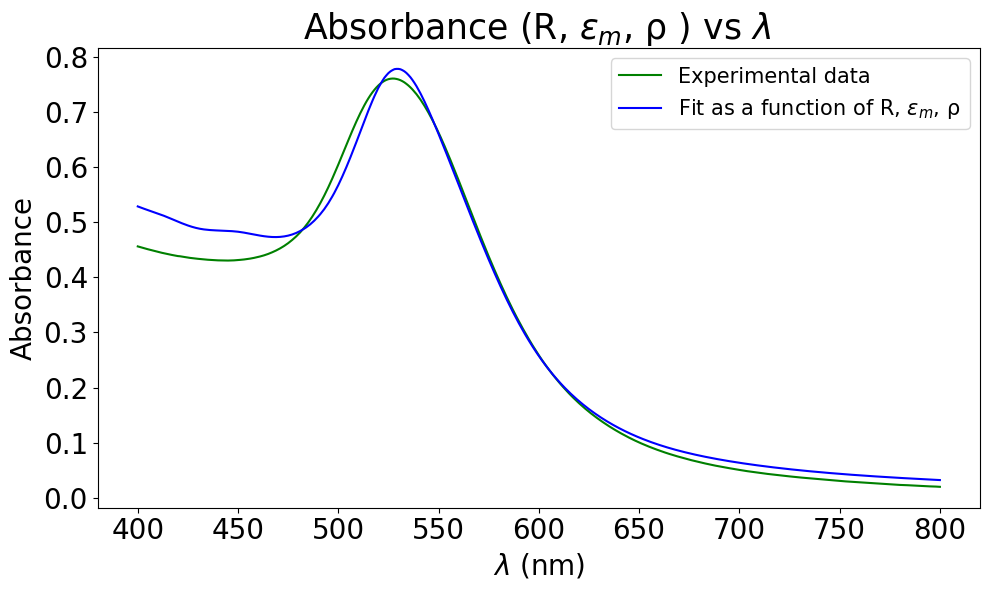

In [7]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(l, absorbance, color="green", label="Experimental data")
plt.plot(l, Absorbance_fitted, color="blue", label="Fit as a function of R, $\epsilon_{m}$, ρ ")
plt.title("Absorbance (R, $\epsilon_{m}$, ρ ) vs $\lambda$ ", fontsize=fs+5)
plt.xlabel(r"$\lambda$ (nm)", fontdict={"fontsize": fs})
plt.xticks(fontsize=fs)
plt.ylabel("Absorbance", fontdict={"fontsize": fs})
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs//4*3)
plt.tight_layout()

# FITTING: size dependent, double fits

In [8]:
#fixing epsilonm to our guess (assuming epsilonm=n^2 with n=1.333 knowing we are in water)
par_fit_epsilonmfix, par_cov_epsilonmfix = curve_fit(Absorbance_epsilonmfix, l_r, absorbance_r, p0=(R_guess, rho_guess))
Absorbance_fitted_epsilonmfix = Absorbance_epsilonmfix(l, R=par_fit_epsilonmfix[0], rho=par_fit_epsilonmfix[1])

with open("outputfile.txt", "a") as outfile:
    multiwrite(outfile, "Fit restricted to 470nm-570nm:")
    multiwrite(outfile, "R = " + str(par_fit_epsilonmfix[0]) + " nm, with error " + str(np.sqrt(par_cov_epsilonmfix[0,0])) + " nm")
    multiwrite(outfile, "rho = " + str(par_fit_epsilonmfix[1]) + " nm**-3, with error " + str(np.sqrt(par_cov_epsilonmfix[1,1])) + " nm**-3")
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_fitted_epsilonmfix)))
    multiwrite(outfile, "")



#fixing rho to the one obtained previously
def Absorbance_rhofix(l, R, epsilonm):
    return Absorbance(l, R, epsilonm, par_fit_epsilonmfix[1])

par_fit_rhofix, par_cov_rhofix = curve_fit(Absorbance_rhofix, l_r, absorbance_r, p0=(R_guess, epsilonm_guess))
Absorbance_fitted_rhofix = Absorbance_rhofix(l, R=par_fit_rhofix[0], epsilonm=par_fit_rhofix[1])

with open("outputfile.txt", "a") as outfile:
    multiwrite(outfile, "Fit restricted to 470nm-570nm:")
    multiwrite(outfile, "R = " + str(par_fit_rhofix[0]) + " nm, with error " + str(np.sqrt(par_cov_rhofix[0,0])) + " nm")
    multiwrite(outfile, "epsilonm = " + str(par_fit_rhofix[1]) + " with error " + str(np.sqrt(par_cov_rhofix[1,1])))
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_fitted_rhofix)))
    multiwrite(outfile, "")



#fixing epsilonm to the previous value
def Absorbance_epsilonmfixfit(l, R, rho):
    return Absorbance(l, R, par_fit_rhofix[1], rho)

par_fit_epsilonmfixfit, par_cov_epsilonmfixfit = curve_fit(Absorbance_epsilonmfixfit, l_r, absorbance_r, p0=(R_guess, rho_guess))
Absorbance_fitted_epsilonmfixfit = Absorbance_epsilonmfixfit(l, R=par_fit_epsilonmfixfit[0], rho=par_fit_epsilonmfixfit[1])

with open("outputfile.txt", "a") as outfile:
    multiwrite(outfile, "Fit restricted to 470nm-570nm:")
    multiwrite(outfile, "R = " + str(par_fit_epsilonmfixfit[0]) + " nm, with error " + str(np.sqrt(par_cov_epsilonmfixfit[0,0])) + " nm")
    multiwrite(outfile, "rho = " + str(par_fit_epsilonmfixfit[1]) + " nm**-3, with error " + str(np.sqrt(par_cov_epsilonmfixfit[1,1])) + " nm**-3")
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_fitted_epsilonmfixfit)))
    multiwrite(outfile, "")



#using f as a parameter
def Absorbance_f_epsilonmfix(l, R, f):
    return Absorbance_f(l, R, par_fit_rhofix[1], f)

par_fit_f_epsilonmfix, par_cov_f_epsilonmfix = curve_fit(Absorbance_f_epsilonmfix, l_r, absorbance_r, p0=(R_guess, f_guess))
Absorbance_fitted_f_epsilonmfix = Absorbance_f_epsilonmfix(l, R=par_fit_f_epsilonmfix[0], f=par_fit_f_epsilonmfix[1])

with open("outputfile.txt", "a") as outfile:
    multiwrite(outfile, "Fit restricted to 470nm-570nm:")
    multiwrite(outfile, "R = " + str(par_fit_f_epsilonmfix[0]) + " nm, with error " + str(np.sqrt(par_cov_f_epsilonmfix[0,0])) + " nm")
    multiwrite(outfile, "f = " + str(par_fit_f_epsilonmfix[1]) + " with error " + str(np.sqrt(par_cov_f_epsilonmfix[1,1])))
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_fitted_f_epsilonmfix)))
    multiwrite(outfile, "")




#USEFUL COMMENTS 
    # do a fit fixing epsilonm to epsilonm_guess and find (R, rho) pair
        # note: this fit is probably going to give shit because R and rho are obviously correlated
        # so there's a curve of values that basically all give the same fit
        # really we should use the filling fraction, because that is what really matters, together with R
        # but we're asked to do it, so just do it and hope
        # possibly put some soundaries so that we don't get R<1nm (as in the triple fit)
        # if you have time and want to improve the results it might be a good idea to really use (R, f) pair, even if we weren't asked to do so
    # also do the (R, epsilonm) fit fixing rho either to rho_guess or to rho_fit (after updating it)
        # this will give no problems
    # update epsilonm_fit, ... values to the found values
    # do some plots of the results

Fit restricted to 470nm-570nm:
R = 3.3840445660096368 nm, with error 0.13749351902249496 nm
rho = 1.1013064157188276e-08 nm**-3, with error 1.4400024753890278e-09 nm**-3
Chi-squared = 0.8335872950069589

Fit restricted to 470nm-570nm:
R = 3.5108356582936846 nm, with error 0.009411048544255615 nm
epsilonm = 2.135895800126656 with error 0.01051138277168445
Chi-squared = 0.6086505917975116

Fit restricted to 470nm-570nm:
R = 3.1250445837279774 nm, with error 0.07163706399977349 nm
rho = 1.6011067336676335e-08 nm**-3, with error 1.1817117044404292e-09 nm**-3
Chi-squared = 0.8939008233757189

Fit restricted to 470nm-570nm:
R = 3.1250454369346636 nm, with error 0.0716359671169235 nm
f = 2.0468099547704518e-06 with error 1.2109791641463692e-08
Chi-squared = 0.8938997813387495



# FITTING: Chi squared maps

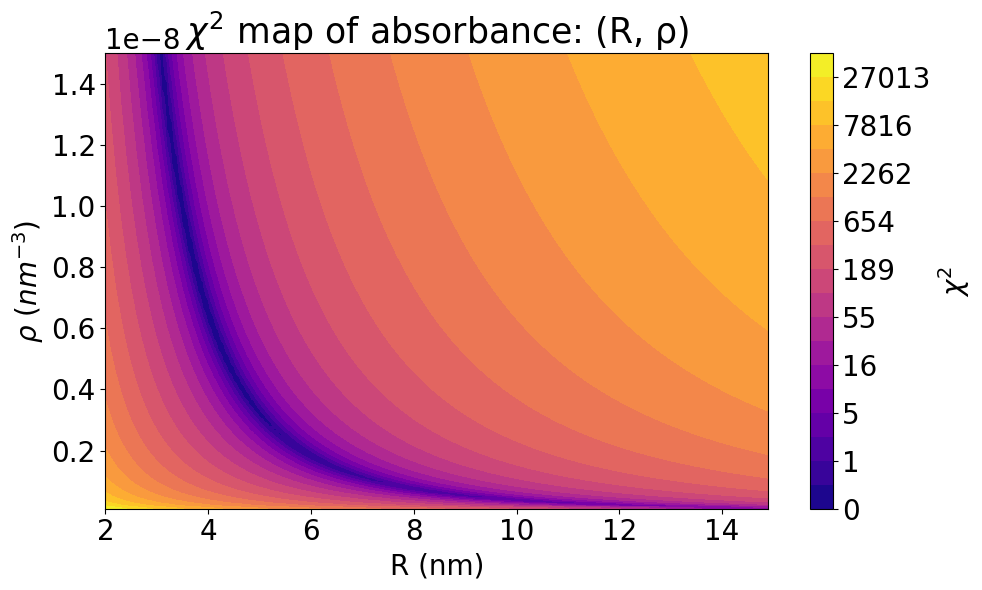

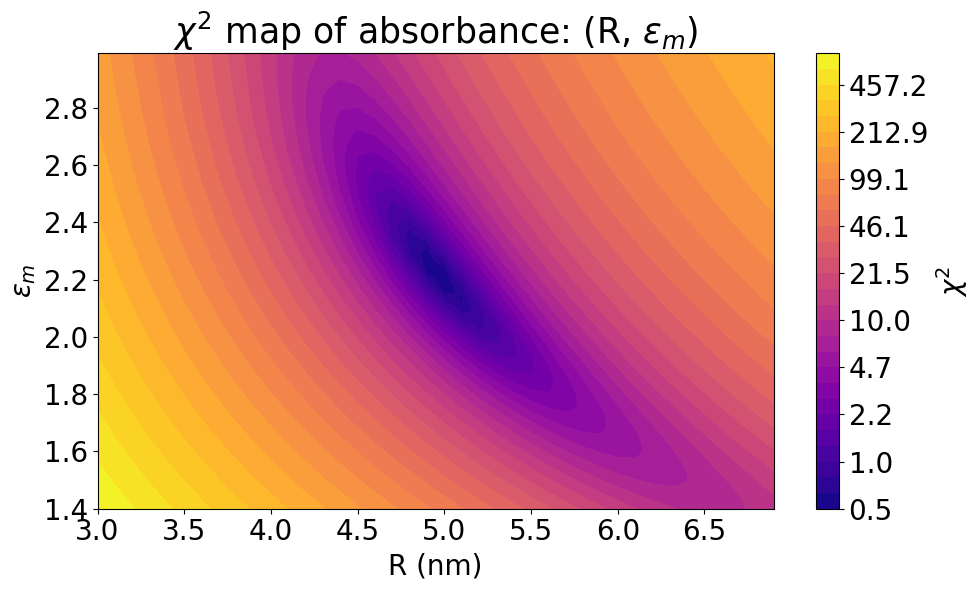

In [9]:
R_domain_1 = np.arange(2, 15, 0.1)
rho_domain = np.arange(1*10**-10, 15*10**-9, 10**-10)
epsilonm_domain = np.arange(1.4, 3, 0.01)
R_domain_2 = np.arange(3, 7, 0.1)

Chi_R_rho_values = np.zeros((len(R_domain_1), len(rho_domain)))    
for i in range(len(R_domain_1)):
    for j in range(len(rho_domain)):
        Chi_R_rho_values[i, j] = Chi_R_rho(R_domain_1[i], rho_domain[j])
        
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
contour_plot = plt.contourf(R_domain_1, rho_domain, Chi_R_rho_values.transpose(),
                            np.logspace(np.log10(Chi_R_rho_values.min()), np.log10(Chi_R_rho_values.max()), 20), locator=ticker.LogLocator(), cmap="plasma")
colbar = plt.colorbar()
colbar.set_label(label=r"$\chi^2$",size=fs)
colbar.ax.tick_params(labelsize=fs)
plt.title(r"$\chi^2$ map of absorbance: (R, ρ)", fontsize=fs+5)
plt.xlabel("R (nm)", fontdict={"fontsize": fs})
plt.xticks(fontsize=fs)
plt.ylabel(r"$\rho \ (nm^{-3})$", fontdict={"fontsize": fs})
plt.yticks(fontsize=fs)
t = ax.yaxis.get_offset_text()
t.set_size(fs)
plt.tight_layout()


Chi_R_epsilonm_values = np.zeros((len(R_domain_2), len(epsilonm_domain)))
for i in range(len(R_domain_2)):
    for j in range(len(epsilonm_domain)):
        Chi_R_epsilonm_values[i, j] = Chi_R_epsilonm(R_domain_2[i], epsilonm_domain[j])

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
contour_plot = plt.contourf(R_domain_2, epsilonm_domain, Chi_R_epsilonm_values.transpose(),
                            np.logspace(np.log10(Chi_R_epsilonm_values.min()), np.log10(Chi_R_epsilonm_values.max()), 30),
                            locator=ticker.LogLocator(), cmap="plasma")
colbar = plt.colorbar()
colbar.set_label(label=r"$\chi^2$",size=fs)
colbar.ax.tick_params(labelsize=fs)
plt.title(r"$\chi^2$ map of absorbance: (R, $\epsilon_m$)", fontsize=fs+5)
plt.xlabel("R (nm)", fontdict={"fontsize": fs})
plt.xticks(fontsize=fs)
plt.ylabel(r"$\epsilon_m$", fontdict={"fontsize": fs})
plt.yticks(fontsize=fs)
t = ax.yaxis.get_offset_text()
t.set_size(fs)
plt.tight_layout()

# PLOTTING: size dependent, double fits

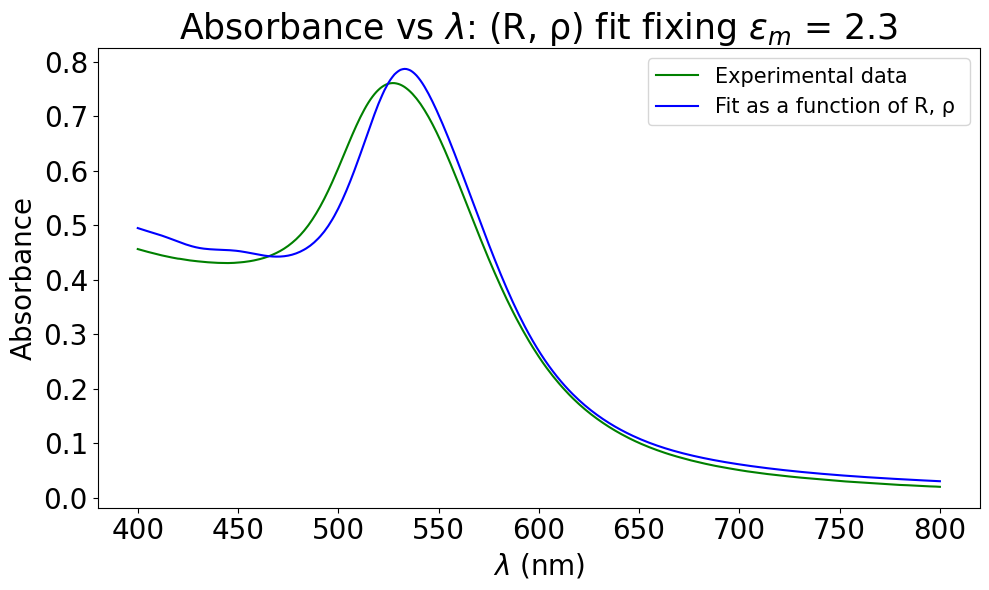

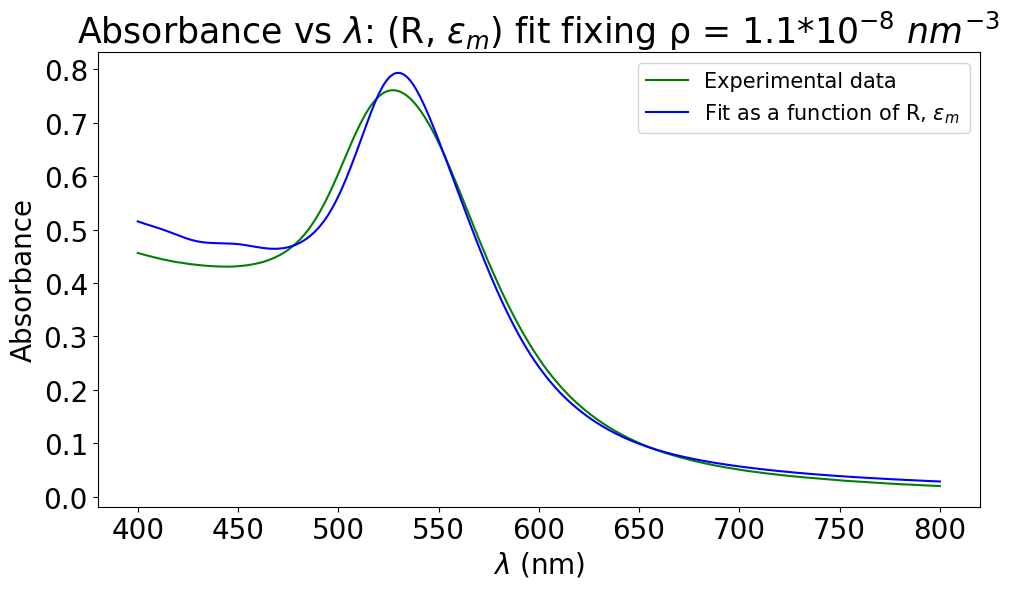

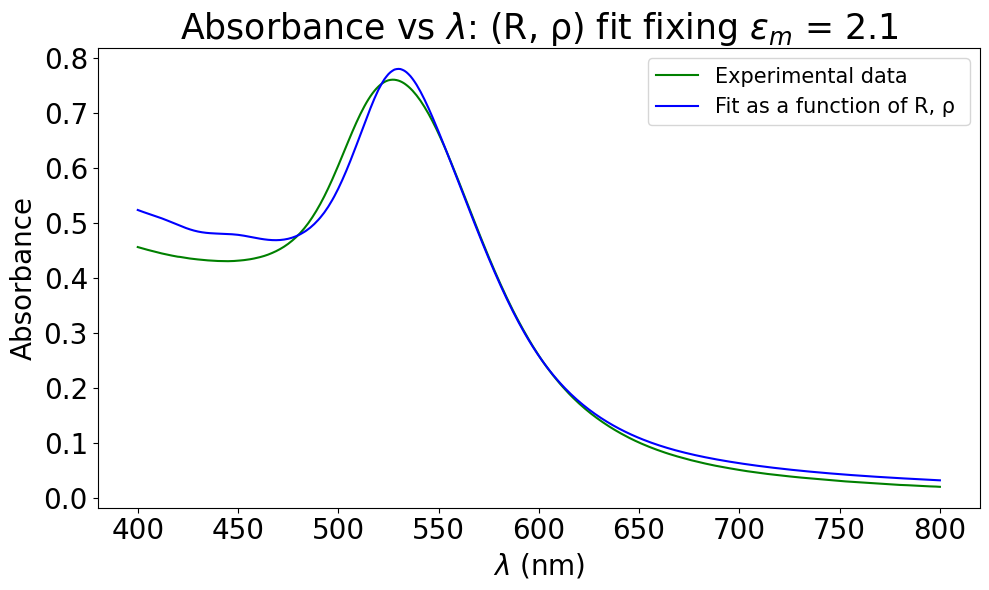

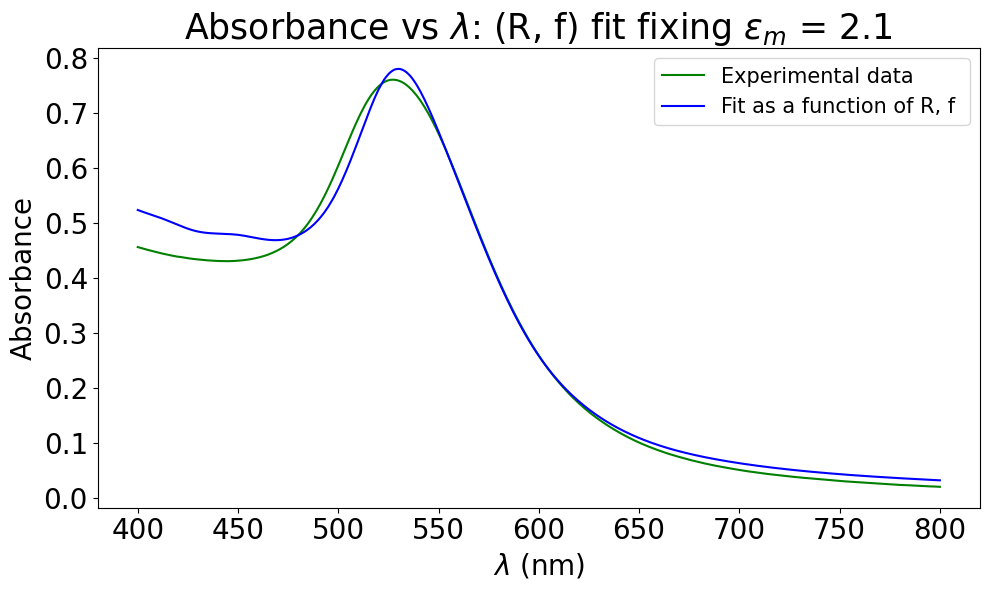

In [10]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(l, absorbance, color="green", label="Experimental data")
plt.plot(l, Absorbance_fitted_epsilonmfix, color="blue", label="Fit as a function of R, ρ ")
plt.title("Absorbance vs $\lambda$: (R, ρ) fit fixing $\epsilon_{m}$ = 2.3", fontsize=fs+5)
plt.xlabel(r"$\lambda$ (nm)", fontdict={"fontsize": fs})
plt.xticks(fontsize=fs)
plt.ylabel("Absorbance", fontdict={"fontsize": fs})
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs//4*3)
plt.tight_layout()


plt.figure(figsize=(10, 6), dpi=100)
plt.plot(l, absorbance, color="green", label="Experimental data")
plt.plot(l, Absorbance_fitted_rhofix, color="blue", label="Fit as a function of R, $\epsilon_{m}$ ")
plt.title("Absorbance vs $\lambda$: (R, $\epsilon_{m}$) fit fixing ρ = 1.1*$10^{-8} \ nm^{-3}$", fontsize=fs+5)
plt.xlabel(r"$\lambda$ (nm)", fontdict={"fontsize": fs})
plt.xticks(fontsize=fs)
plt.ylabel("Absorbance", fontdict={"fontsize": fs})
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs//4*3)
plt.tight_layout()


plt.figure(figsize=(10, 6), dpi=100)
plt.plot(l, absorbance, color="green", label="Experimental data")
plt.plot(l, Absorbance_fitted_epsilonmfixfit, color="blue", label="Fit as a function of R, ρ ")
plt.title("Absorbance vs $\lambda$: (R, ρ) fit fixing $\epsilon_{m}$ = 2.1", fontsize=fs+5)
plt.xlabel(r"$\lambda$ (nm)", fontdict={"fontsize": fs})
plt.xticks(fontsize=fs)
plt.ylabel("Absorbance", fontdict={"fontsize": fs})
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs//4*3)
plt.tight_layout()


plt.figure(figsize=(10, 6), dpi=100)
plt.plot(l, absorbance, color="green", label="Experimental data")
plt.plot(l, Absorbance_fitted_f_epsilonmfix, color="blue", label="Fit as a function of R, f ")
plt.title("Absorbance vs $\lambda$: (R, f) fit fixing $\epsilon_{m}$ = 2.1", fontsize=fs+5)
plt.xlabel(r"$\lambda$ (nm)", fontdict={"fontsize": fs})
plt.xticks(fontsize=fs)
plt.ylabel("Absorbance", fontdict={"fontsize": fs})
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs//4*3)
plt.tight_layout()